In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.metrics import mean_squared_error
from sentence_transformers import SentenceTransformer
import joblib
import seaborn as sns

C:\Users\ashis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
def evaluate_models(models, X_test, y_test):
    error_analysis = {}
    for model_name, model in models.items():
        print(f"Evaluating {model_name}...")
        y_pred = model.predict(X_test)
        cm=confusion_matrix(y_test, y_pred)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_proba))
        print(f"{model_name} RMSE: {rmse}")
        print(f"Accuracy of {model_name}:{accuracy_score(y_test,y_pred)}")
        print(f"\nClassification Report for {model_name}:\n", classification_report(y_test, y_pred))
        print(f"Confusion Matrix for {model_name}:\n")
        class_labels=[1,2,3,4,5]
        plt.figure(figsize=(8, 6))  
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Confusion Matrix")
        plt.show()
    return error_analysis

In [3]:
train_errors = []
val_errors = []
def hyperparameter_tuning(models, param_grids, X_train, y_train, X_test, y_test):
    best_estimators = {}
    i = 0
    for model_name, model in models.items():
        print(f"Optimizing {model_name}...")
        grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        best_estimators[model_name] = grid_search.best_estimator_
        print(f"Best params for {model_name}: {grid_search.best_params_}")
        print(f"\nGrid search results for {model_name}:")
        results = grid_search.cv_results_
        for mean_score, params in zip(results['mean_test_score'], results['params']):
            print(f"Params: {params} => Accuracy: {mean_score:.4f}")
        joblib.dump(best_estimators[model_name], f'{model_name}_best_model.joblib')
        
    return best_estimators

In [12]:
def split_set(X,y,test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0, stratify=y)
    return X_train, X_test, y_train, y_test

In [7]:
def load_feature(parquet_file,unifile,bifile):
    df = pd.read_parquet(parquet_file)
    y = df['stars'].values  # extract target values
    un = pd.read_parquet(unifile)
    display(un.shape)
    emb1 = np.array(un['tfidf_u'].tolist())
    bi = pd.read_parquet(bifile)
    emb2 = np.array(bi['tfidf_ub'].tolist())
    display(bi.shape)
    X = np.hstack([ emb1, emb2])
    return X,y

In [8]:
X,y = load_feature('df_f_embeddings.parquet','df_tfidf_uni_embeddings_f.parquet','df_tfidf_bi_embeddings_f.parquet')

(50000, 3)

(50000, 3)

In [9]:
X.shape

(50000, 100)

In [10]:
y.shape

(50000,)

In [13]:
X_train, X_test, y_train, y_test = split_set(X,y,0.25)

In [14]:
models = {
    'knn': KNeighborsClassifier(),
}
param_grids = {
    'knn': {'n_neighbors': [11,15,19,21,23], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']},
}

# Perform hyperparameter tuning
best_estimators = hyperparameter_tuning(models, param_grids, X_train, y_train,X_test,y_test)

Optimizing knn...
Best params for knn: {'metric': 'euclidean', 'n_neighbors': 23, 'weights': 'distance'}

Grid search results for knn:
Params: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'} => Accuracy: 0.4007
Params: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'} => Accuracy: 0.4028
Params: {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'uniform'} => Accuracy: 0.4086
Params: {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'distance'} => Accuracy: 0.4110
Params: {'metric': 'euclidean', 'n_neighbors': 19, 'weights': 'uniform'} => Accuracy: 0.4126
Params: {'metric': 'euclidean', 'n_neighbors': 19, 'weights': 'distance'} => Accuracy: 0.4126
Params: {'metric': 'euclidean', 'n_neighbors': 21, 'weights': 'uniform'} => Accuracy: 0.4133
Params: {'metric': 'euclidean', 'n_neighbors': 21, 'weights': 'distance'} => Accuracy: 0.4132
Params: {'metric': 'euclidean', 'n_neighbors': 23, 'weights': 'uniform'} => Accuracy: 0.4156
Params: {'metric': 'eucl

Evaluating knn...
knn RMSE: 3.1672041623173803
Accuracy of knn:0.41728

Classification Report for knn:
               precision    recall  f1-score   support

         1.0       0.54      0.72      0.62      2500
         2.0       0.37      0.25      0.30      2500
         3.0       0.32      0.26      0.29      2500
         4.0       0.36      0.41      0.38      2500
         5.0       0.43      0.45      0.44      2500

    accuracy                           0.42     12500
   macro avg       0.40      0.42      0.41     12500
weighted avg       0.40      0.42      0.41     12500

Confusion Matrix for knn:



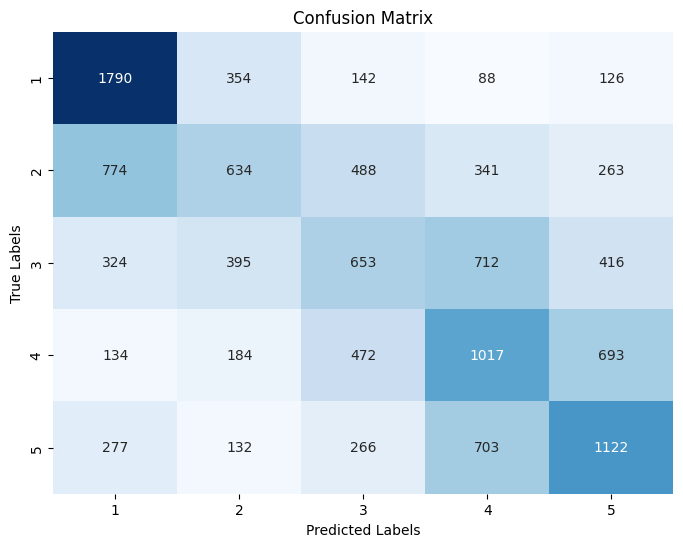

{}

In [15]:
evaluate_models(best_estimators, X_test, y_test)

In [16]:
models = {
    'logistic': LogisticRegression(max_iter=10000),
}
param_grids = {
    'logistic': {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'], 'solver': ['lbfgs','saga']},
}

# Perform hyperparameter tuning
best_estimators = hyperparameter_tuning(models, param_grids, X_train, y_train,X_test,y_test)

Optimizing logistic...
Best params for logistic: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}

Grid search results for logistic:
Params: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'} => Accuracy: 0.4664
Params: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'} => Accuracy: 0.4663
Params: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'} => Accuracy: 0.4927
Params: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'} => Accuracy: 0.4928
Params: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'} => Accuracy: 0.4997
Params: {'C': 1, 'penalty': 'l2', 'solver': 'saga'} => Accuracy: 0.4994
Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'} => Accuracy: 0.4998
Params: {'C': 10, 'penalty': 'l2', 'solver': 'saga'} => Accuracy: 0.4998


Evaluating logistic...
logistic RMSE: 3.1737241313822717
Accuracy of logistic:0.49952

Classification Report for logistic:
               precision    recall  f1-score   support

         1.0       0.66      0.74      0.70      2500
         2.0       0.44      0.40      0.42      2500
         3.0       0.41      0.35      0.38      2500
         4.0       0.43      0.43      0.43      2500
         5.0       0.52      0.58      0.55      2500

    accuracy                           0.50     12500
   macro avg       0.49      0.50      0.49     12500
weighted avg       0.49      0.50      0.49     12500

Confusion Matrix for logistic:



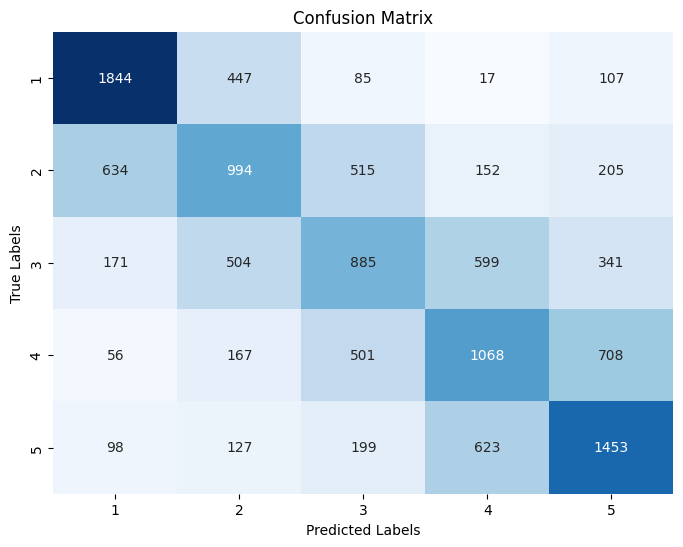

{}

In [17]:
evaluate_models(best_estimators, X_test, y_test)

Evaluating logistic...
logistic RMSE: 3.1737241313822717
Accuracy of logistic:0.49952

Classification Report for logistic:
               precision    recall  f1-score   support

         1.0       0.66      0.74      0.70      2500
         2.0       0.44      0.40      0.42      2500
         3.0       0.41      0.35      0.38      2500
         4.0       0.43      0.43      0.43      2500
         5.0       0.52      0.58      0.55      2500

    accuracy                           0.50     12500
   macro avg       0.49      0.50      0.49     12500
weighted avg       0.49      0.50      0.49     12500

Confusion Matrix for logistic:



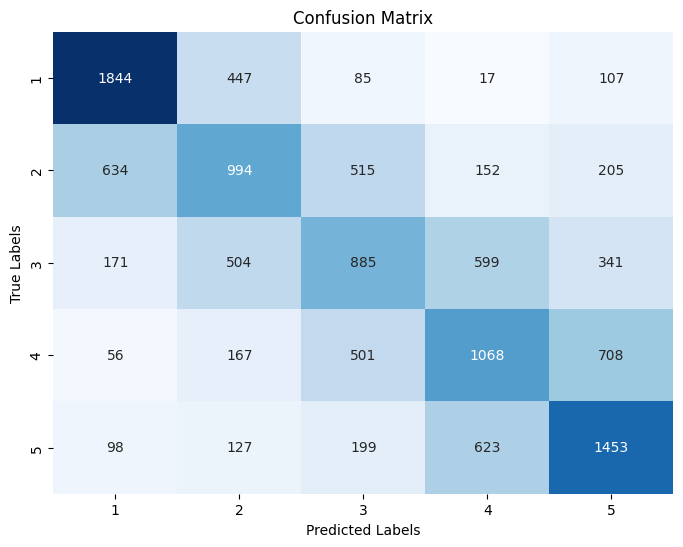

{}

In [19]:
evaluate_models(best_estimators, X_test, y_test)

In [23]:
from sklearn.naive_bayes import GaussianNB

models = {
    'naive_bayes': GaussianNB()
    
}

param_grids = {
    'naive_bayes': {}  # GaussianNB has no hyperparameters to tune
}
best_estimators = hyperparameter_tuning(models, param_grids, X_train, y_train,X_test,y_test)

Optimizing naive_bayes...
Best params for naive_bayes: {}

Grid search results for naive_bayes:
Params: {} => Accuracy: 0.3530


Evaluating naive_bayes...
naive_bayes RMSE: 3.226737452274003
Accuracy of naive_bayes:0.35544

Classification Report for naive_bayes:
               precision    recall  f1-score   support

         1.0       0.52      0.51      0.51      2500
         2.0       0.35      0.21      0.26      2500
         3.0       0.37      0.17      0.24      2500
         4.0       0.27      0.64      0.38      2500
         5.0       0.44      0.24      0.31      2500

    accuracy                           0.36     12500
   macro avg       0.39      0.36      0.34     12500
weighted avg       0.39      0.36      0.34     12500

Confusion Matrix for naive_bayes:



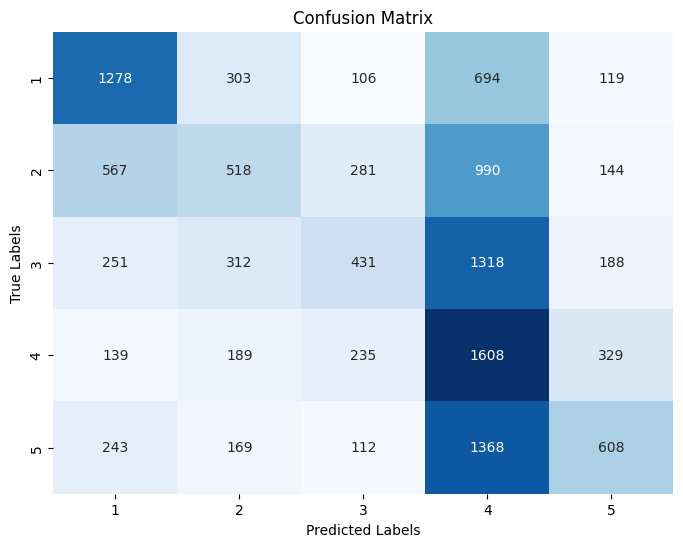

{}

In [24]:
evaluate_models(best_estimators, X_test, y_test)

In [25]:
from sklearn.ensemble import VotingClassifier
import joblib

knn = joblib.load('knnf.joblib')
lr = joblib.load('logisticf.joblib')
nb = joblib.load('naive_bayesf.joblib')
# Create a voting ensemble model
ensemble = VotingClassifier(
    estimators=[('knn', knn), ('lr', lr),('nb',nb)],
    voting='soft' 
)

# Train and evaluate the ensemble model
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)
accuracy_score(y_test, y_pred)

0.40696

In [26]:
from sklearn.ensemble import StackingClassifier

ensemble = StackingClassifier(
    estimators=[('knn', knn), ('lr', lr),('nb',nb)],
    final_estimator=LogisticRegression()
)

# Train and evaluate
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)
accuracy_score(y_test, y_pred)

0.49544

Evaluating ensemble...
ensemble RMSE: 3.174963727887697
Accuracy of ensemble:0.49544

Classification Report for ensemble:
               precision    recall  f1-score   support

         1.0       0.67      0.72      0.70      2500
         2.0       0.42      0.42      0.42      2500
         3.0       0.39      0.35      0.37      2500
         4.0       0.43      0.43      0.43      2500
         5.0       0.53      0.56      0.55      2500

    accuracy                           0.50     12500
   macro avg       0.49      0.50      0.49     12500
weighted avg       0.49      0.50      0.49     12500

Confusion Matrix for ensemble:



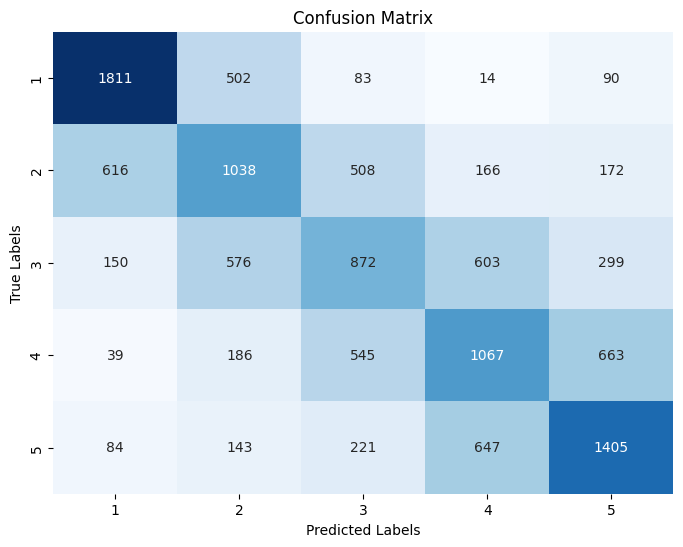

{}

In [28]:
D = {'ensemble':ensemble}
evaluate_models(D, X_test, y_test)